## Import modules

In [1]:
# sklearn
from sklearn.datasets import fetch_openml

import numpy as np

import matplotlib.pyplot as plt

## Loading data

In [2]:
full_data = fetch_openml("mnist_784")

In [3]:
full_data['data']

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [4]:
full_data['target'].shape

(70000,)

In [5]:
train_size = 60000
test_size = 10000

## Separate full_data to train and test

In [6]:
train_data = {'data': full_data['data'][:train_size], 'target': full_data['target'][:train_size]}
test_data = {'data': full_data['data'][train_size:], 'target': full_data['target'][train_size:]}

## Let's visualize first 10 digits from train:

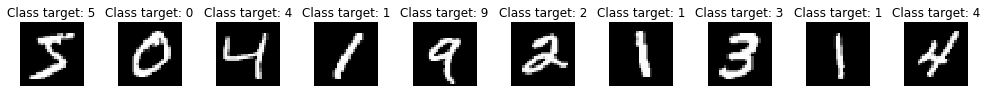

In [7]:
digits_to_show = 10
fig = plt.figure(figsize=(15, 15))
for i in range(digits_to_show):
    ax = fig.add_subplot(1, digits_to_show + 1, i+1)
    ax.imshow(train_data['data'][i].reshape(28, 28), cmap=plt.get_cmap('Greys_r'))
    ax.set_title('Class target: ' + train_data['target'][i])
    ax.axis("off")
plt.tight_layout()
plt.show()

In [45]:
from 

In [72]:
KNN_model = KNNClassifier(10, strategy='brute')

In [73]:
%%time
KNN_model.fit(X=train_data['data'], y=train_data['target'])

CPU times: user 14.9 ms, sys: 7.8 ms, total: 22.7 ms
Wall time: 21.7 ms


In [74]:
%%time
# KNN_model.find_kneighbors(train_data['data'][:5000], True)[1]
# print('DONE')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.77 µs


In [75]:
%%time
preds = KNN_model.predict(test_data['data'])

CPU times: user 1min 48s, sys: 2.23 s, total: 1min 51s
Wall time: 19.8 s


In [76]:
sum(preds.astype(int) - test_data['target'].astype(int) == 0) / test_data['target'].size

0.9665

In [ ]:
#brute - 0.9871
#kd_tree - 0.
#ball_tree